In [38]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [39]:
BASE_PATH = "/kaggle/input/pixel-play-26"
DATA_ROOT = os.path.join(BASE_PATH, os.listdir(BASE_PATH)[0])
AVENUE_PATH = os.path.join(DATA_ROOT, "Avenue_Corrupted")
DATASET = os.path.join(AVENUE_PATH, "Dataset")

TRAIN_VIDEOS = os.path.join(DATASET, "training_videos")
TEST_VIDEOS  = os.path.join(DATASET, "testing_videos")

print("Train clips:", len(os.listdir(TRAIN_VIDEOS)))
print("Test clips:", len(os.listdir(TEST_VIDEOS)))


Train clips: 16
Test clips: 21


In [40]:
IMG_SIZE = 128        # 128x128 is stable & fast
BATCH_SIZE = 32
EPOCHS = 5
LR = 1e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [41]:
def load_gray_frame(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = normalize_image(img)
    return img


In [42]:
def normalize_image(img):
    """
    img: uint8 [0,255]
    return: float32 [0,1]
    """
    return img.astype(np.float32) / 255.0


In [43]:
def patch_error_map(recon, target, patch_size=16, topk=1):
    """
    recon, target: tensors (1, 1, H, W)
    patch_size: spatial patch size
    topk: take mean of top-k patch errors (1 = max)
    """
    err_map = (recon - target).pow(2).squeeze(0).squeeze(0)  # (H, W)
    H, W = err_map.shape

    patch_scores = []
    for i in range(0, H, patch_size):
        for j in range(0, W, patch_size):
            patch = err_map[i:i+patch_size, j:j+patch_size]
            patch_scores.append(patch.mean())

    patch_scores = torch.stack(patch_scores)
    topk_scores = torch.topk(patch_scores, k=topk).values
    return topk_scores.mean().item()


In [44]:
class FrameDiffDataset(Dataset):
    def __init__(self, root_dir):
        self.pairs = []

        for clip in sorted(os.listdir(root_dir)):
            clip_path = os.path.join(root_dir, clip)
            frames = sorted(os.listdir(clip_path))

            # start from index 1 (need t and t-1)
            for i in range(1, len(frames)):
                prev_f = os.path.join(clip_path, frames[i - 1])
                curr_f = os.path.join(clip_path, frames[i])
                self.pairs.append((prev_f, curr_f))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        prev_path, curr_path = self.pairs[idx]

        prev_img = load_gray_frame(prev_path)
        curr_img = load_gray_frame(curr_path)

        diff = np.abs(curr_img - prev_img)

        # shape: (1, H, W)
        diff = np.expand_dims(diff, axis=0)

        return torch.tensor(diff, dtype=torch.float32)



In [45]:
train_dataset = FrameDiffDataset(TRAIN_VIDEOS)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

In [46]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # 128 → 64
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # 64 → 32
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),# 32 → 16
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out


In [47]:
model = ConvAutoencoder().to(DEVICE)
criterion = nn.MSELoss(reduction="none")
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [48]:
model.train()

for epoch in range(EPOCHS):
    epoch_loss = 0
    for x in tqdm(train_loader):
        x = x.to(DEVICE)
        optimizer.zero_grad()
        recon = model(x)
        loss = criterion(recon, x).mean()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {epoch_loss/len(train_loader):.6f}")


100%|██████████| 288/288 [00:47<00:00,  6.08it/s]


Epoch 1/5 | Loss: 0.006163


100%|██████████| 288/288 [00:44<00:00,  6.46it/s]


Epoch 2/5 | Loss: 0.001122


100%|██████████| 288/288 [00:41<00:00,  6.93it/s]


Epoch 3/5 | Loss: 0.001118


100%|██████████| 288/288 [00:37<00:00,  7.75it/s]


Epoch 4/5 | Loss: 0.001117


100%|██████████| 288/288 [00:37<00:00,  7.76it/s]

Epoch 5/5 | Loss: 0.001119


In [49]:
model.eval()
anomaly_scores = []

with torch.no_grad():
    for clip in sorted(os.listdir(TEST_VIDEOS)):
        clip_path = os.path.join(TEST_VIDEOS, clip)
        frames = sorted(os.listdir(clip_path))

        for i in range(1, len(frames)):
            # ---- Load consecutive frames ----
            prev_path = os.path.join(clip_path, frames[i - 1])
            curr_path = os.path.join(clip_path, frames[i])

            prev_img = load_gray_frame(prev_path)
            curr_img = load_gray_frame(curr_path)

            # ---- Frame difference (THIS WAS MISSING) ----
            diff = np.abs(curr_img - prev_img)
            diff = torch.tensor(diff).unsqueeze(0).unsqueeze(0).to(DEVICE)

            # ---- Reconstruction ----
            recon = model(diff)

            # ---- PATCH-BASED anomaly score ----
            error = patch_error_map(
                recon,
                diff,
                patch_size=16,
                topk=1
            )

            # ---- Correct ID extraction ----
            video_id = int(clip)
            frame_id = int(frames[i].replace("frame_", "").replace(".jpg", ""))

            anomaly_scores.append({
                "Id": f"{video_id}_{frame_id}",
                "raw_score": error
            })




In [50]:
for clip in sorted(os.listdir(TEST_VIDEOS)):
    clip_path = os.path.join(TEST_VIDEOS, clip)
    print("Clip:", clip)
    print("Example frame:", os.listdir(clip_path)[0])
    break


Clip: 01
Example frame: frame_01094.jpg


In [51]:
df_debug = pd.DataFrame(anomaly_scores)
df_debug.head(10)


,Id,raw_score
0,1_940,0.043566
1,1_941,0.059496
2,1_942,0.070442
3,1_943,0.054838
4,1_944,0.399078
5,1_945,0.392950
6,1_946,0.083186
7,1_947,0.096402
8,1_948,0.067763
9,1_949,0.048610


In [52]:
df_debug = (
    df_debug
    .groupby("Id", as_index=False)["raw_score"]
    .max()
)

In [53]:
print("After duplicate resolution:")
print(len(df_debug), df_debug["Id"].nunique())


After duplicate resolution:
11685 11685


In [54]:
df_debug["Predicted"] = df_debug["raw_score"].rank(pct=True)


In [55]:
print(df_debug.columns)


Index(['Id', 'raw_score', 'Predicted'], dtype='object')


count    11685.000000
mean         0.078243
std          0.141050
min          0.000010
25%          0.004672
50%          0.008878
75%          0.027168
max          0.419083
Name: raw_score, dtype: float64

<Axes: >

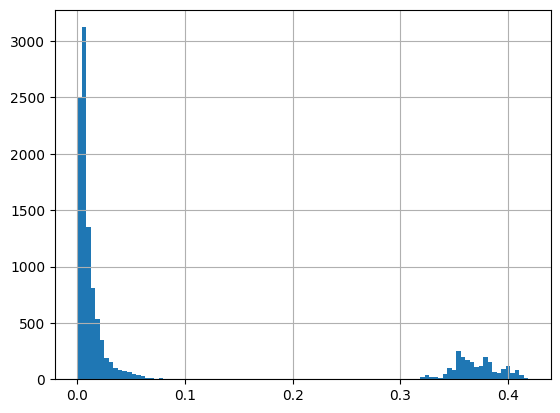

In [56]:
display(df_debug["raw_score"].describe())
df_debug["raw_score"].hist(bins=100)


In [57]:
# Build expected Id list from test directory
expected_ids = []

for clip in sorted(os.listdir(TEST_VIDEOS)):
    clip_path = os.path.join(TEST_VIDEOS, clip)
    frames = sorted(os.listdir(clip_path))
    for frame in frames:
        video_id = int(clip)
        frame_id = int(frame.replace("frame_", "").replace(".jpg", ""))
        expected_ids.append(f"{video_id}_{frame_id}")

expected_ids = set(expected_ids)
submitted_ids = set(submission["Id"])

print("Expected frames:", len(expected_ids))
print("Submitted frames:", len(submitted_ids))
print("Missing frames:", len(expected_ids - submitted_ids))


Expected frames: 11706
Submitted frames: 11706
Missing frames: 0


In [58]:
missing_ids = expected_ids - set(df_debug["Id"])
print("Missing frames:", len(missing_ids))


Missing frames: 21


In [59]:
if len(missing_ids) > 0:
    missing_df = pd.DataFrame({
        "Id": list(missing_ids),
        "raw_score": 0.0
    })
    df_debug = pd.concat([df_debug, missing_df], ignore_index=True)


In [60]:
print("Final coverage check:")
print("Total rows:", len(df_debug))
print("Unique Ids:", df_debug["Id"].nunique())


Final coverage check:
Total rows: 11706
Unique Ids: 11706


In [61]:
df = pd.DataFrame(anomaly_scores)
df_debug["Predicted"] = df_debug["raw_score"].rank(pct=True)



In [62]:
df_debug["Predicted"].describe()
df_debug.sort_values("Predicted", ascending=False).head(10)


,Id,raw_score,Predicted
6437,2_14,0.419083,1.000000
6892,2_55,0.418915,0.999915
6429,2_132,0.417317,0.999829
6887,2_545,0.415935,0.999744
6886,2_544,0.415833,0.999658
6424,2_128,0.415833,0.999573
6731,2_404,0.415579,0.999487
6194,2_101,0.415252,0.999402
6489,2_187,0.414437,0.999317
6787,2_455,0.414270,0.999231


In [63]:
submission = df_debug[["Id", "Predicted"]]

submission[["vid", "fid"]] = submission["Id"].str.split("_", expand=True).astype(int)
submission = (
    submission
    .sort_values(["vid", "fid"])
    .drop(columns=["vid", "fid"])
    .reset_index(drop=True)
)

print(len(submission), submission["Id"].nunique())


11706 11706


In [65]:
submission.to_csv("submission.csv", index=False)
